# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# Prepare Dataset

In [3]:
train_data_url = "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv"
test_data_url = "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/test.tsv"
imdb_dataset_url = "https://raw.githubusercontent.com/Ankit152/IMDB-sentiment-analysis/master/IMDB-Dataset.csv"

In [4]:
train_df = pd.read_csv(train_data_url, delimiter='\t', header=None)
test_df = pd.read_csv(test_data_url, delimiter='\t', header=None)
imdb_dataset = pd.read_csv(imdb_dataset_url)

In [5]:
imdb_dataset['sentiment'] = imdb_dataset['sentiment'].map({'positive': 1, 'negative': 0})

In [6]:
print(train_df.head())

                                                   0  1
0  a stirring , funny and finally transporting re...  1
1  apparently reassembled from the cutting room f...  0
2  they presume their audience wo n't sit still f...  0
3  this is a visually stunning rumination on love...  1
4  jonathan parker 's bartleby should have been t...  1


In [7]:
X_train, X_val, y_train, y_val = train_test_split(train_df.drop(1, axis=1), train_df[1], test_size=0.2, random_state=42)
print(f"Length of train dataset: {len(X_train)}")
print(f"Length of validation dataset: {len(X_val)}")
X_test = test_df.drop(1, axis=1)
y_test = test_df[1]
print(f"Length of test dataset: {len(X_test)}")

Length of train dataset: 5536
Length of validation dataset: 1384
Length of test dataset: 1821


In [8]:
X_tv_imdb, X_test_imdb, y_tv_imdb, y_test_imdb = train_test_split(imdb_dataset.drop("sentiment", axis=1), imdb_dataset['sentiment'], random_state=42)
X_train_imdb, X_val_imdb, y_train_imdb, y_val_imdb = train_test_split(X_tv_imdb, y_tv_imdb, random_state=42)
print(f"Length of imdb train set: {len(X_train_imdb)}")
print(f"Length of imdb validation set: {len(X_val_imdb)}")
print(f"Length of imdb test set: {len(X_test_imdb)}")

Length of imdb train set: 28125
Length of imdb validation set: 9375
Length of imdb test set: 12500


## Define Model architecture

In [9]:
class Model(nn.Module):
    def __init__(self, input_size, dropout=0.3):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.fc5(x)
        return x

model = Model(10000)

In [10]:
indent = "\t"
print("Model Summary:")
print("="*50)
print(f"Input Size: 10000")
print(f"Layer 1: Linear(10000, 512)")
print(indent + f"Parameters: {10000 * 512 + 512}")
print(indent + f"Activation: ReLU + Dropout(0.3)")
print(f"Layer 2: Linear(512, 256)")
print(indent + f"Parameters: {512 * 256 + 256}")
print(indent + f"Activation: ReLU + Dropout(0.3)")
print(f"Layer 3: Linear(256, 128)")
print(indent + f"Parameters: {256 * 128 + 128}")
print(indent + f"Activation: ReLU + Dropout(0.3)")
print(f"Layer 4: Linear(128, 64)")
print(indent + f"Parameters: {128 * 64 + 64}")
print(indent + f"Activation: ReLU + Dropout(0.3)")
print(f"Layer 5: Linear(64, 2)")
print(indent + f"Parameters: {64 * 2 + 2}")
print(f"Total Parameters: {sum(p.numel() for p in model.parameters())}")

Model Summary:
Input Size: 10000
Layer 1: Linear(10000, 512)
	Parameters: 5120512
	Activation: ReLU + Dropout(0.3)
Layer 2: Linear(512, 256)
	Parameters: 131328
	Activation: ReLU + Dropout(0.3)
Layer 3: Linear(256, 128)
	Parameters: 32896
	Activation: ReLU + Dropout(0.3)
Layer 4: Linear(128, 64)
	Parameters: 8256
	Activation: ReLU + Dropout(0.3)
Layer 5: Linear(64, 2)
	Parameters: 130
Total Parameters: 5293122


## Get Bert-uncased embeddings

In [ ]:
from huggingface_hub import login

login("ENTER YOUR ACCESS TOKEN HERE")

In [12]:
def get_embeddings(data, model_name="bert-base-uncased", batch_size=16):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    print(f"Using device: {device}")

    model = AutoModel.from_pretrained(model_name)
    model.to(device)
    model.eval()

    embeddings = []

    for i in range(0, len(data), batch_size):
        batch_texts = data[i: i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
        with torch.no_grad():
            output = model(**inputs)
        batch_embeddings = output.last_hidden_state.mean(dim=1).detach().cpu().numpy()
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)


In [13]:
X_train = X_train.to_numpy().reshape(-1)
X_val = X_val.to_numpy().reshape(-1)
X_test = X_test.to_numpy().reshape(-1)
X_train_embeddings = get_embeddings(X_train.tolist())
X_val_embeddings = get_embeddings(X_val.tolist())
X_test_embeddings = get_embeddings(X_test.tolist())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Using device: cuda


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Using device: cuda
Using device: cuda


### Create Dataloaders for training and testing

In [14]:
X_train_embeddings = torch.Tensor(X_train_embeddings)
X_val_embeddings = torch.Tensor(X_val_embeddings)
y_train = torch.Tensor(y_train.to_numpy())
y_val = torch.Tensor(y_val.to_numpy())
X_test_embeddings = torch.Tensor(X_test_embeddings)
y_test = torch.Tensor(y_test.to_numpy())

print(f"Shape of X_train_embeddings: {X_train_embeddings.shape}")
print(f"Shape of X_val_embeddings: {X_val_embeddings.shape}")
print(f"Shape of X_test_embeddings: {X_test_embeddings.shape}")

Shape of X_train_embeddings: torch.Size([5536, 768])
Shape of X_val_embeddings: torch.Size([1384, 768])
Shape of X_test_embeddings: torch.Size([1821, 768])


In [15]:
train_dataset = TensorDataset(X_train_embeddings, y_train)
val_dataset = TensorDataset(X_val_embeddings, y_val)
test_dataset = TensorDataset(X_test_embeddings, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Train the model on STT 2 dataset

In [16]:
writer = SummaryWriter("runs/embeddings")
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model = Model(768).to(device)

In [17]:
def test_model(dataloader, model, criterion):
    model.eval()
    loss_ = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for x_, y_ in dataloader:
            x_, y_ = x_.to(device), y_.to(device)
            outputs = model(x_)
            loss = criterion(outputs, y_.long())

            loss_ += loss.item() * x_.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == y_.long()).sum().item()
            total += x_.size(0)
    avg_loss = loss_/total
    acc = correct/total
    return avg_loss, acc

In [18]:
train_loss = []
train_acc = []
val_loss = []
val_acc = []
best_val = 0.0

In [19]:
for epoch in range(epochs):
    total = 0
    correct = 0
    loss_ = 0.0
    model.train()
    for x_, y_ in train_loader:
        x_, y_ = x_.to(device), y_.to(device)
        optimizer.zero_grad()
        outputs = model(x_)
        loss = criterion(outputs, y_.long())
        loss.backward()
        optimizer.step()
        loss_ += loss.item() * x_.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == y_.long()).sum().item()
        total += x_.size(0)
    avg_loss = loss_/total
    avg_acc = correct/total
    train_loss.append(avg_loss)
    train_acc.append(avg_acc)
    val_loss_, val_acc_ = test_model(val_loader, model, criterion)
    val_loss.append(val_loss_)
    val_acc.append(val_acc_)
    writer.add_scalar("Loss/train", avg_loss, epoch)
    writer.add_scalar("Loss/val", val_loss_, epoch)
    writer.add_scalar("Accuracy/train", avg_acc, epoch)
    writer.add_scalar("Accuracy/val", val_acc_, epoch)
    print(f"Epoch: {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Train Acc: {avg_acc:.4f} | Val Loss: {val_loss_:.4f} | Val Acc: {val_acc_:.4f}")
    if (val_acc_ > best_val):
        best_val = val_acc_
        torch.save(model.state_dict(), "best_model.pth")
        print("Model saved!")

Epoch: 1/10 | Train Loss: 0.6942 | Train Acc: 0.4834 | Val Loss: 0.6935 | Val Acc: 0.4848
Model saved!
Epoch: 2/10 | Train Loss: 0.6942 | Train Acc: 0.4790 | Val Loss: 0.6935 | Val Acc: 0.4848
Epoch: 3/10 | Train Loss: 0.6939 | Train Acc: 0.4879 | Val Loss: 0.6935 | Val Acc: 0.4848
Epoch: 4/10 | Train Loss: 0.6942 | Train Acc: 0.4792 | Val Loss: 0.6935 | Val Acc: 0.4848
Epoch: 5/10 | Train Loss: 0.6939 | Train Acc: 0.4854 | Val Loss: 0.6935 | Val Acc: 0.4848
Epoch: 6/10 | Train Loss: 0.6940 | Train Acc: 0.4807 | Val Loss: 0.6935 | Val Acc: 0.4848
Epoch: 7/10 | Train Loss: 0.6939 | Train Acc: 0.4875 | Val Loss: 0.6935 | Val Acc: 0.4848
Epoch: 8/10 | Train Loss: 0.6939 | Train Acc: 0.4854 | Val Loss: 0.6935 | Val Acc: 0.4848
Epoch: 9/10 | Train Loss: 0.6938 | Train Acc: 0.4872 | Val Loss: 0.6935 | Val Acc: 0.4848
Epoch: 10/10 | Train Loss: 0.6939 | Train Acc: 0.4809 | Val Loss: 0.6935 | Val Acc: 0.4848


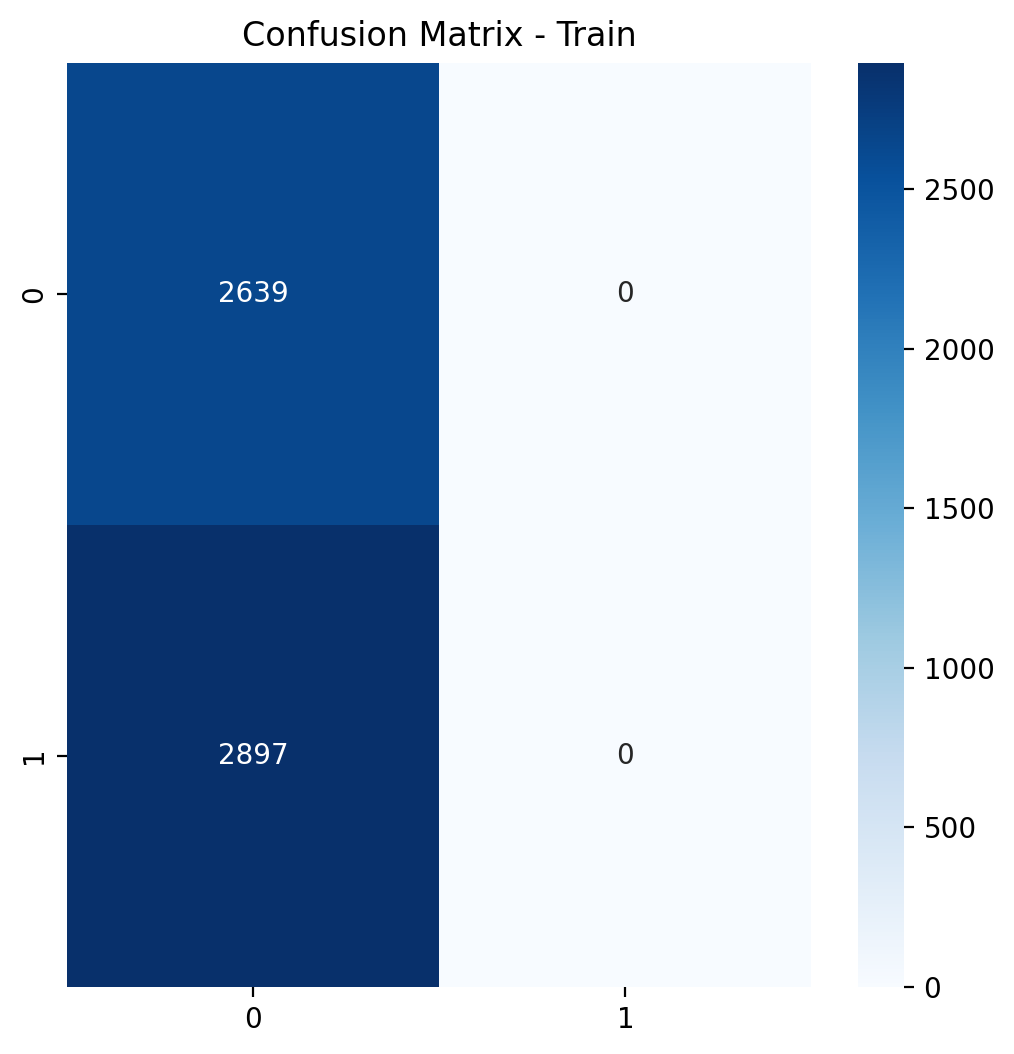

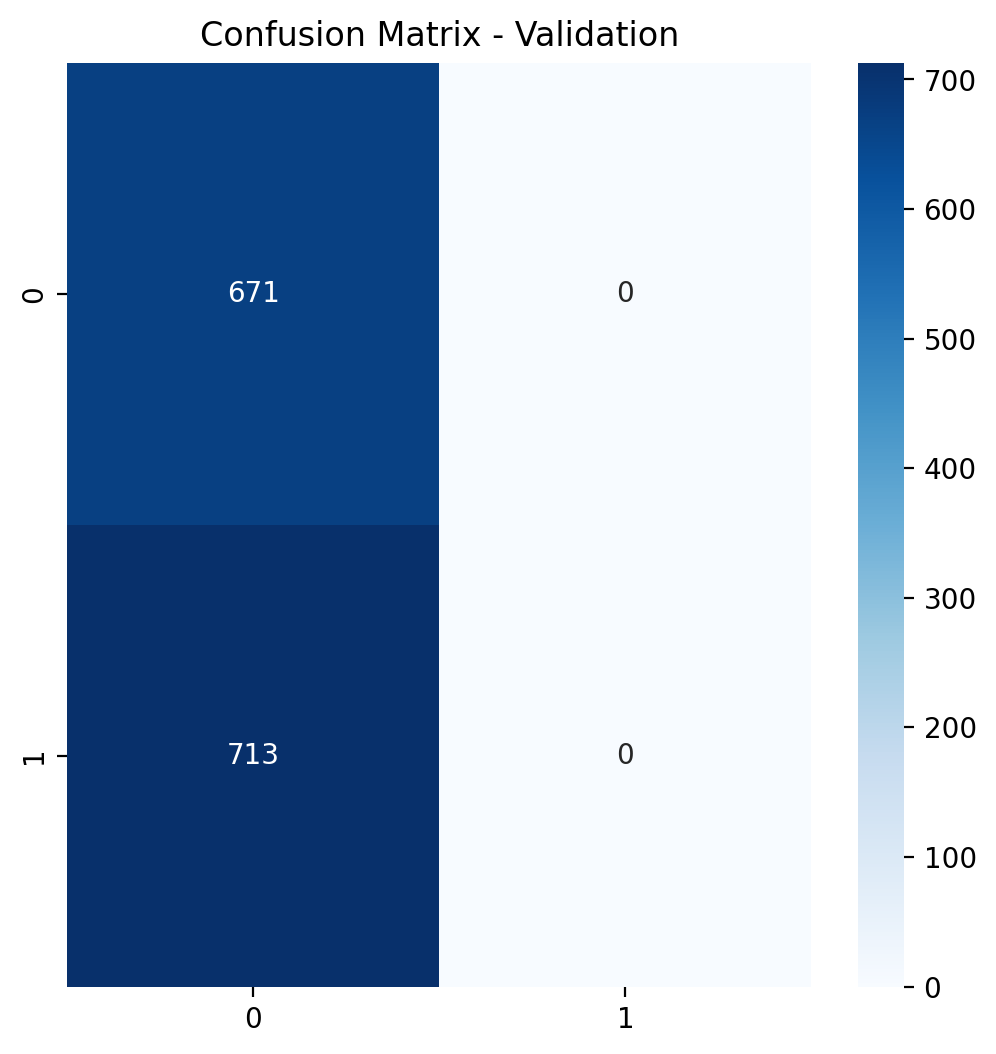

In [20]:
model.eval()
with torch.no_grad():
    output_train = model(X_train_embeddings.to(device))
    preds_train = torch.argmax(output_train, dim=1)
    cm_train = confusion_matrix(y_train.cpu(), preds_train.cpu())
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title('Confusion Matrix - Train')
    plt.show()
    writer.add_figure('Confusion Matrix/Train', fig)

    output_val = model(X_val_embeddings.to(device))
    preds_val = torch.argmax(output_val, dim=1)
    cm_val = confusion_matrix(y_val.cpu(), preds_val.cpu())
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title('Confusion Matrix - Validation')
    plt.show()
    writer.add_figure('Confusion Matrix/Validation', fig)

### Performance on test data

Test Accuracy: 0.5008237361907959


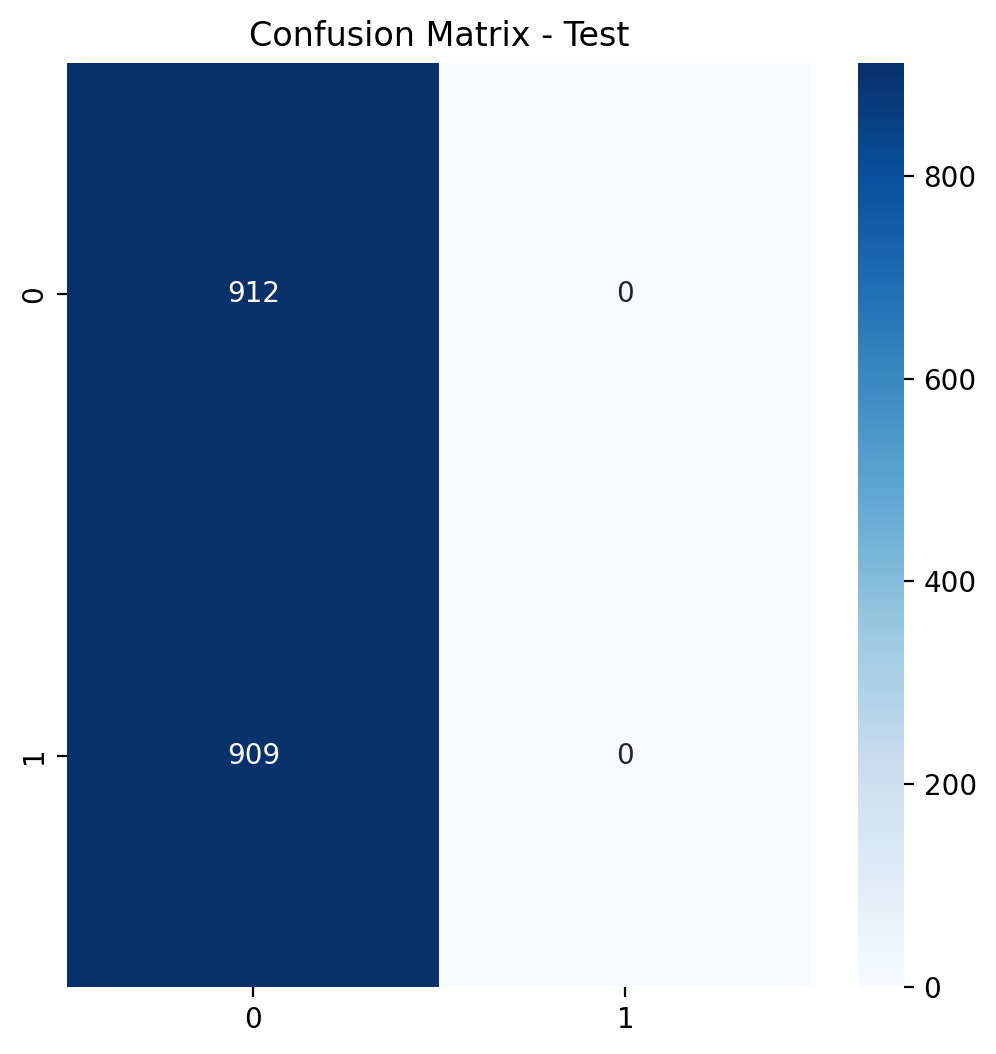

In [21]:
model.eval()
with torch.no_grad():
    output_test = model(X_test_embeddings.to(device))
    preds_test = torch.argmax(output_test, dim=1)
    cm_test = confusion_matrix(y_test.cpu(), preds_test.cpu())
    acc_test = (preds_test.cpu() == y_test).float().mean()
    print(f"Test Accuracy: {acc_test}")
    writer.add_scalar("Accuracy/test", acc_test, 0)
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title('Confusion Matrix - Test')
    plt.show()
    writer.add_figure('Confusion Matrix/Test', fig)
writer.close()

## COntinual Learning from checkpoint

In [22]:
best_model = Model(768)
best_model.load_state_dict(torch.load("best_model.pth"))
best_model.to(device)

Model(
  (fc1): Linear(in_features=768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)

In [25]:
X_train_imdb, X_val_imdb, y_train_imdb, y_val_imdb = train_test_split(X_train_imdb, y_train_imdb, random_state=42)
# X_train_imdb = X_train_imdb.to_numpy().reshape(-1)
# X_val_imdb = X_val_imdb.to_numpy().reshape(-1)

X_train_imdb_embeddings = get_embeddings(X_train_imdb.tolist())
X_val_imdb_embeddings = get_embeddings(X_val_imdb.tolist())
X_train_imdb_embeddings = torch.Tensor(X_train_imdb_embeddings)
X_val_imdb_embeddings = torch.Tensor(X_val_imdb_embeddings)
y_train_imdb = torch.Tensor(y_train_imdb.to_numpy())
y_val_imdb = torch.Tensor(y_val_imdb.to_numpy())

train_dataset = TensorDataset(X_train_imdb_embeddings, y_train_imdb)
val_dataset = TensorDataset(X_val_imdb_embeddings, y_val_imdb)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Using device: cuda
Using device: cuda


In [26]:
print(f"Shape of X_train_imdb_embeddings: {X_train_imdb_embeddings.shape}")
print(f"Shape of X_val_imdb_embeddings: {X_val_imdb_embeddings.shape}")

Shape of X_train_imdb_embeddings: torch.Size([11864, 768])
Shape of X_val_imdb_embeddings: torch.Size([3955, 768])


## Training on IMDB dataset for 10 epochs

In [27]:
writer = SummaryWriter("runs/embeddings_imdb")
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-7)

In [28]:
for epoch in range(epochs):
    total = 0
    correct = 0
    loss_ = 0.0
    model.train()
    for x_, y_ in train_loader:
        x_, y_ = x_.to(device), y_.to(device)
        optimizer.zero_grad()
        outputs = best_model(x_)
        loss = criterion(outputs, y_.long())
        loss.backward()
        optimizer.step()
        loss_ += loss.item() * x_.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == y_.long()).sum().item()
        total += x_.size(0)
    avg_loss = loss_/total
    avg_acc = correct/total
    train_loss.append(avg_loss)
    train_acc.append(avg_acc)
    val_loss_, val_acc_ = test_model(val_loader, model, criterion)
    val_loss.append(val_loss_)
    val_acc.append(val_acc_)
    writer.add_scalar("Loss/train", avg_loss, epoch)
    writer.add_scalar("Loss/val", val_loss_, epoch)
    writer.add_scalar("Accuracy/train", avg_acc, epoch)
    writer.add_scalar("Accuracy/val", val_acc_, epoch)
    print(f"Epoch: {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Train Acc: {avg_acc:.4f} | Val Loss: {val_loss_:.4f} | Val Acc: {val_acc_:.4f}")

Epoch: 1/10 | Train Loss: 0.6932 | Train Acc: 0.5018 | Val Loss: 0.6929 | Val Acc: 0.5067
Epoch: 2/10 | Train Loss: 0.6933 | Train Acc: 0.5035 | Val Loss: 0.6929 | Val Acc: 0.5067
Epoch: 3/10 | Train Loss: 0.6933 | Train Acc: 0.5010 | Val Loss: 0.6929 | Val Acc: 0.5067
Epoch: 4/10 | Train Loss: 0.6932 | Train Acc: 0.5008 | Val Loss: 0.6929 | Val Acc: 0.5067
Epoch: 5/10 | Train Loss: 0.6934 | Train Acc: 0.4976 | Val Loss: 0.6929 | Val Acc: 0.5067
Epoch: 6/10 | Train Loss: 0.6932 | Train Acc: 0.5038 | Val Loss: 0.6929 | Val Acc: 0.5067
Epoch: 7/10 | Train Loss: 0.6934 | Train Acc: 0.5001 | Val Loss: 0.6929 | Val Acc: 0.5067
Epoch: 8/10 | Train Loss: 0.6932 | Train Acc: 0.5048 | Val Loss: 0.6929 | Val Acc: 0.5067
Epoch: 9/10 | Train Loss: 0.6932 | Train Acc: 0.5006 | Val Loss: 0.6929 | Val Acc: 0.5067
Epoch: 10/10 | Train Loss: 0.6934 | Train Acc: 0.5051 | Val Loss: 0.6929 | Val Acc: 0.5067


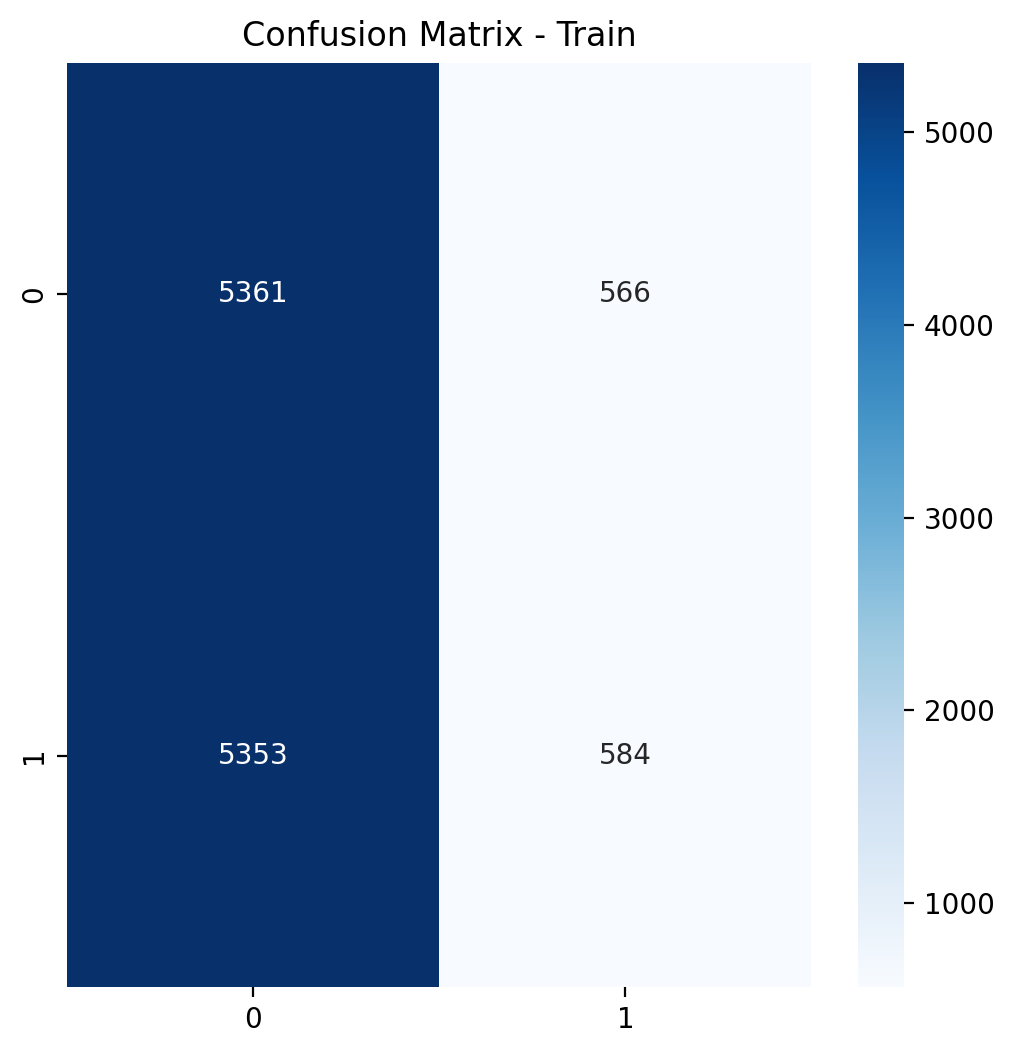

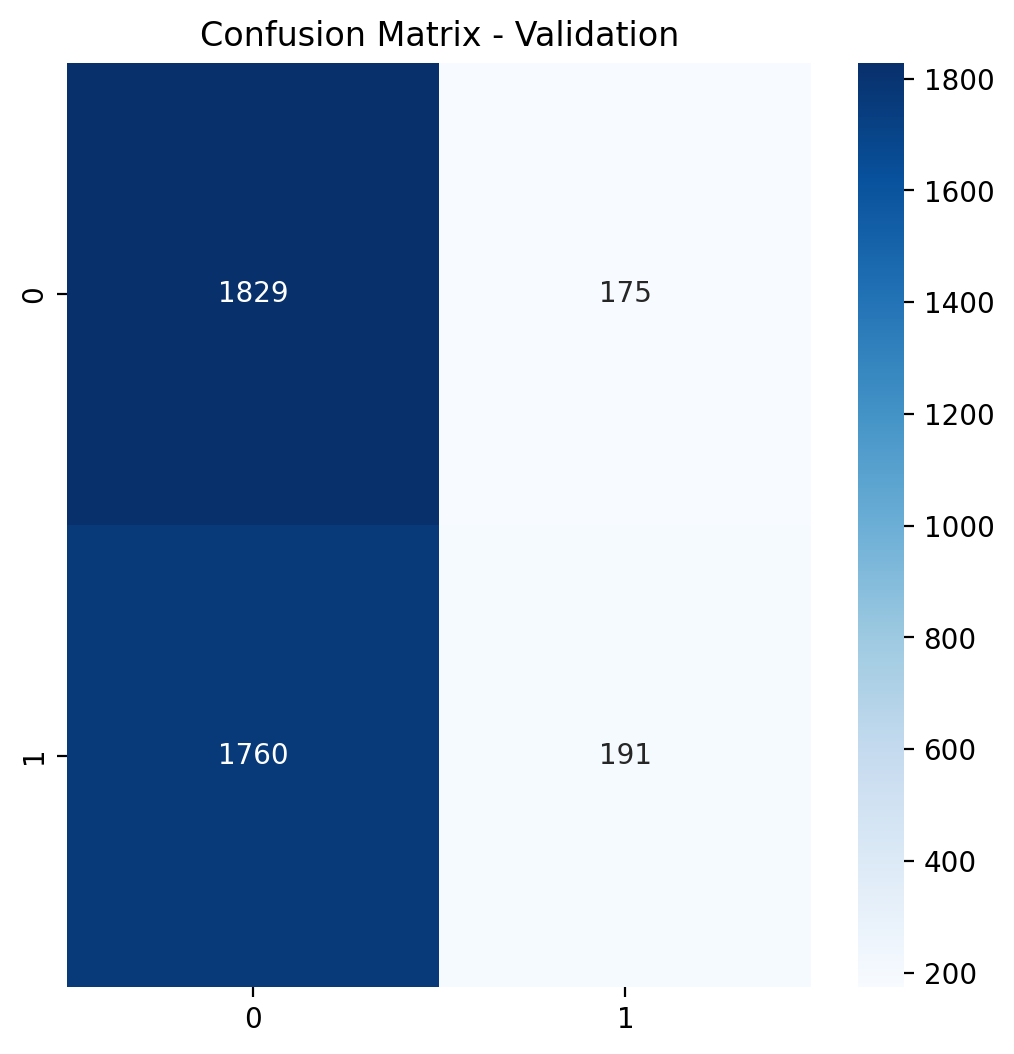

In [29]:
model.eval()
with torch.no_grad():
    output_train = best_model(X_train_imdb_embeddings.to(device))
    preds_train = torch.argmax(output_train, dim=1)
    cm_train = confusion_matrix(y_train_imdb.cpu(), preds_train.cpu())

    fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title('Confusion Matrix - Train')
    plt.show()
    writer.add_figure('Confusion Matrix/Train', fig)

    output_val = best_model(X_val_imdb_embeddings.to(device))
    preds_val = torch.argmax(output_val, dim=1)
    cm_val = confusion_matrix(y_val_imdb.cpu(), preds_val.cpu())

    fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title('Confusion Matrix - Validation')
    plt.show()
    writer.add_figure('Confusion Matrix/Validation', fig)
writer.close()

In [30]:
while True:
  print(0)

Streaming output truncated to the last 5000 lines.
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0

KeyboardInterrupt: 